# Data Cleaning & Preprocessing — Online Retail
This notebook performs a careful cleaning of the **Online Retail** dataset.
For every action we:
1. Inspect the relevant columns (missing values / unusual values).
2. Print how many rows **would** be affected.


In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
# Cell: Imports and load
import os
import pandas as pd
import numpy as np
from typing import Tuple
from IPython.display import display, HTML

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 80)

# Load file (adjust path if needed)
file_path = os.path.join(os.getcwd(), 'data/Online Retail.xlsx')
if not os.path.exists(file_path):
    raise FileNotFoundError(f"'Online Retail.xlsx' not found at: {file_path}. Place the file in project root.")
print("Loading dataset from:", file_path)
df = pd.read_excel(file_path)
print("Raw shape:", df.shape)
display(df.head())


Loading dataset from: /Users/mahi0606/Desktop/Retail_Stock_Analyzer_Model/data/Online Retail.xlsx
Raw shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


We examine columns, types, basic stats, and missing-value counts so decisions are data-driven.


In [ ]:
# Cell: overview
print("Columns and dtypes:")
display(df.dtypes)

print("\nBasic stats for numeric columns:")
display(df.describe(include=[np.number]).T)

print("\nNon-null counts per column:")
non_null = df.count().sort_values()
display(non_null)

print("\nMissing value counts (absolute and percent):")
missing_abs = df.isna().sum()
missing_pct = (missing_abs / len(df) * 100).round(2)
missing_df = pd.concat([missing_abs, missing_pct], axis=1)
missing_df.columns = ['missing_count', 'missing_pct']
missing_df = missing_df.sort_values(by='missing_count', ascending=False)
display(missing_df)

Columns and dtypes:


InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


Basic stats for numeric columns:


,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0



Non-null counts per column:


CustomerID     406829
Description    540455
InvoiceNo      541909
StockCode      541909
Quantity       541909
InvoiceDate    541909
UnitPrice      541909
Country        541909
dtype: int64


Missing value counts (absolute and percent):


,missing_count,missing_pct
CustomerID,135080,24.93
Description,1454,0.27
InvoiceNo,0,0.00
StockCode,0,0.00
Quantity,0,0.00
InvoiceDate,0,0.00
UnitPrice,0,0.00
Country,0,0.00


**Observation**:  
- `CustomerID` often has many missing values in this dataset (24.93% missing, likely anonymous purchases).  
- `Description` sometimes missing (0.27% missing) — we can try to impute using StockCode mapping.  
- `InvoiceDate` is already in datetime format, no conversion needed.

In [ ]:
# Cell: convert types safely and show results
def convert_types_inspect(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    # Convert InvoiceDate -> datetime (coerce errors to NaT so we can count them)
    df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate'], errors='coerce')
    # Convert CustomerID to object (keeps NaN)
    df2['CustomerID'] = df2['CustomerID'].astype(object)
    # Show how many InvoiceDate conversions failed
    num_invalid_dates = df2['InvoiceDate'].isna().sum()
    print(f"InvoiceDate invalid/parsing-failed rows: {num_invalid_dates:,} ({num_invalid_dates/len(df2)*100:.2f}%)")
    return df2

df = convert_types_inspect(df)


InvoiceDate invalid/parsing-failed rows: 0 (0.00%)


## 2) Handling missing Description
**Plan:** try to fill missing `Description` from `StockCode -> Description` mapping (most robust), then show how many remain and decide to drop those rows (since Description is necessary for product-level analysis).

In [ ]:
# Cell: impute descriptions with diagnostics
def impute_descriptions_verbose(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    missing_before = df2['Description'].isna().sum()
    print(f"Descriptions missing before imputation: {missing_before:,}")

    # Build mapping from StockCode -> Description using available non-null descriptions
    desc_map = (
        df2.dropna(subset=['Description'])
           .drop_duplicates(subset=['StockCode'])
           .set_index('StockCode')['Description']
           .to_dict()
    )
    # How many rows have a StockCode mapping available but missing description?
    mask_missing_desc = df2['Description'].isna()
    mapped_available = df2.loc[mask_missing_desc, 'StockCode'].isin(desc_map.keys()).sum()
    print(f"Of the missing descriptions, {mapped_available:,} can be filled using StockCode mapping.")

    # Fill using map where possible (non-chained)
    df2['Description'] = np.where(
        df2['Description'].isna() & df2['StockCode'].isin(desc_map.keys()),
        df2['StockCode'].map(desc_map),
        df2['Description']
    )

    missing_after_map = df2['Description'].isna().sum()
    print(f"Missing descriptions after mapping: {missing_after_map:,}")

    # Decide: drop rows that still have no Description
    to_drop = missing_after_map
    print(f"Rows to drop (no Description after imputation): {to_drop:,}")
    df2 = df2.dropna(subset=['Description']).copy()
    print(f"Rows remaining: {len(df2):,}")
    return df2

df = impute_descriptions_verbose(df)


Descriptions missing before imputation: 1,454
Of the missing descriptions, 1,342 can be filled using StockCode mapping.
Missing descriptions after mapping: 112
Rows to drop (no Description after imputation): 112
Rows remaining: 541,797


## 3) Inspect CustomerID missingness and decide policy
We will:
- Show how many rows lack CustomerID (absolute + percent).
- Decide: **keep** rows without CustomerID for general aggregate EDA, but **drop** when preparing for RFM/segmentation (since CustomerID is required there).


In [ ]:
# Cell: examine CustomerID missingness
cust_missing = df['CustomerID'].isna().sum()
print(f"CustomerID missing: {cust_missing:,} ({cust_missing/len(df)*100:.2f}%)")

# Show a sample of rows without CustomerID to understand their pattern
display(df[df['CustomerID'].isna()].sample(min(5, df['CustomerID'].isna().sum()), random_state=1))

print("\nPolicy suggestion:")
print("- For EDA: keep anonymous rows (they contribute to revenue counts).")
print("- For customer-level segmentation (RFM): drop rows without CustomerID.")


CustomerID missing: 134,968 (24.91%)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
79633,542999,21035,SET/2 RED RETROSPOT TEA TOWELS,1,2011-02-02 12:16:00,5.79,NaN,United Kingdom
6260,536876,21411,GINGHAM HEART DOORSTOP RED,1,2010-12-03 11:36:00,8.47,NaN,United Kingdom
106255,545317,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,1,2011-03-01 14:14:00,5.79,NaN,United Kingdom
392186,570688,85115B,S/4 BLACK DISCO PARTITION PANEL,3,2011-10-11 16:29:00,8.29,NaN,United Kingdom
447191,574950,21931,JUMBO STORAGE BAG SUKI,2,2011-11-08 09:29:00,4.13,NaN,United Kingdom



Policy suggestion:
- For EDA: keep anonymous rows (they contribute to revenue counts).
- For customer-level segmentation (RFM): drop rows without CustomerID.


## 4) Remove duplicates, cancelled orders, and invalid quantities/prices
We will:
1. Count duplicates.
2. Count InvoiceNo starting with 'C' (cancelled) — show example rows.
3. Count negative or zero `Quantity` / `UnitPrice`.
4. Print how many rows will be removed if we apply all three filters.


In [ ]:
# Cell: compute counts for potential removals
initial_rows = len(df)
dups_count = df.duplicated().sum()
cancel_mask = df['InvoiceNo'].astype(str).str.startswith('C')
cancel_count = cancel_mask.sum()
non_positive_count = ((df['Quantity'] <= 0) | (df['UnitPrice'] <= 0)).sum()

print(f"Initial rows: {initial_rows:,}")
print(f"Duplicate rows: {dups_count:,}")
print(f"Cancelled orders (InvoiceNo starts with 'C'): {cancel_count:,}")
print(f"Rows with Quantity <= 0 or UnitPrice <= 0: {non_positive_count:,}")

# Show examples for quick inspection
if cancel_count > 0:
    print("\nExample cancelled order rows:")
    display(df[cancel_mask].head())

if non_positive_count > 0:
    print("\nExample non-positive Quantity / UnitPrice rows:")
    display(df[(df['Quantity'] <= 0) | (df['UnitPrice'] <= 0)].head())


Initial rows: 541,797
Duplicate rows: 5,268
Cancelled orders (InvoiceNo starts with 'C'): 9,288
Rows with Quantity <= 0 or UnitPrice <= 0: 11,693

Example cancelled order rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom



Example non-positive Quantity / UnitPrice rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [ ]:
# Cell: apply removals with clear prints
def remove_duplicates_and_invalids(df: pd.DataFrame) -> pd.DataFrame:
    before = len(df)
    df2 = df.drop_duplicates().copy()
    # Remove cancellations
    df2 = df2[~df2['InvoiceNo'].astype(str).str.startswith('C')].copy()
    # Remove non-positive numeric values
    df2 = df2[(df2['Quantity'] > 0) & (df2['UnitPrice'] > 0)].copy()
    after = len(df2)
    print(f"Removed {before - after:,} rows (duplicates + cancellations + non-positive). Now: {after:,} rows.")
    return df2

df = remove_duplicates_and_invalids(df)


Removed 16,919 rows (duplicates + cancellations + non-positive). Now: 524,878 rows.


## 5) Remove clearly non-product StockCodes
We inspect the frequency of the top StockCodes and remove known non-product codes.


In [ ]:
# Cell: inspect top StockCodes and apply removal
top_stockcodes = df['StockCode'].value_counts().head(20)
print("Top 20 StockCodes (count):")
display(top_stockcodes)

# Define an extensible list of codes to remove
non_product_codes = [
    'POST', 'D', 'M', 'DOT', 'CRUK', 'S', 'AMAZONFEE',
    'B', 'BANK CHARGES', 'C2', 'DCGS', 'GIFT', 'PADS',
    'ADJUST', 'TEST'
]

before = len(df)
df = df[~df['StockCode'].isin(non_product_codes)].copy()
after = len(df)
print(f"Removed {before - after:,} rows from non-product StockCodes. Remaining: {after:,}")


Top 20 StockCodes (count):


StockCode
85123A    2253
85099B    2109
22423     2007
47566     1699
20725     1582
84879     1476
22197     1418
22720     1392
21212     1352
22383     1306
20727     1301
22457     1255
23203     1242
22386     1232
22469     1219
21931     1194
22086     1184
22411     1180
22382     1164
22961     1164
Name: count, dtype: int64

Removed 2,309 rows from non-product StockCodes. Remaining: 522,569


## 6) Feature engineering (Sales, time features)
We create `Sales = Quantity * UnitPrice` plus helpful derived time features.
Before creating time features we will confirm `InvoiceDate` has no NaT for the rows we plan to use; print how many NaT remain (if any).


In [ ]:
# Cell: check InvoiceDate NaT after earlier steps
nat_count = df['InvoiceDate'].isna().sum()
print(f"Rows with invalid InvoiceDate (NaT): {nat_count:,}")
if nat_count > 0:
    print("Example rows with invalid InvoiceDate:")
    display(df[df['InvoiceDate'].isna()].head())

# We can either drop these (if small) or keep but exclude from time-based analyses.
# For this pipeline we will drop rows with NaT InvoiceDate because time features are essential for later steps.
threshold_drop_dates = 0  # set to 0 to drop all invalid dates; change if you prefer
if nat_count > threshold_drop_dates:
    before = len(df)
    df = df.dropna(subset=['InvoiceDate']).copy()
    after = len(df)
    print(f"Dropped {before - after:,} rows with invalid InvoiceDate. Remaining: {after:,}")

# Create features
df = df.copy()
df['Sales'] = df['Quantity'] * df['UnitPrice']
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour
df['Quarter'] = df['InvoiceDate'].dt.quarter
df['DayName'] = df['InvoiceDate'].dt.day_name()

print("Feature engineering complete. Sample:")
display(df[['InvoiceDate','Quantity','UnitPrice','Sales','Year','Month','DayName']].head())


Rows with invalid InvoiceDate (NaT): 0
Feature engineering complete. Sample:


,InvoiceDate,Quantity,UnitPrice,Sales,Year,Month,DayName
0,2010-12-01 08:26:00,6,2.55,15.30,2010,12,Wednesday
1,2010-12-01 08:26:00,6,3.39,20.34,2010,12,Wednesday
2,2010-12-01 08:26:00,8,2.75,22.00,2010,12,Wednesday
3,2010-12-01 08:26:00,6,3.39,20.34,2010,12,Wednesday
4,2010-12-01 08:26:00,6,3.39,20.34,2010,12,Wednesday


## 7) Final summary & save cleaned dataset
Show the final shape, top-level stats, and save the cleaned DataFrame for future steps.  
(Remember we kept anonymous rows for aggregate EDA; for RFM you should drop rows without CustomerID)


In [ ]:
# Cell: final summary and save
print("Final cleaned dataset shape:", df.shape)
print("\nColumns overview:")
display(pd.DataFrame({
    'dtype': df.dtypes,
    'non_null_count': df.count(),
    'missing_count': df.isna().sum()
}).sort_values('missing_count', ascending=False))

print("\nTop countries by sales (quick check):")
display(df.groupby('Country')['Sales'].sum().sort_values(ascending=False).head(10))

# Save cleaned file for reuse
clean_path = os.path.join(os.getcwd(), 'online_retail_cleaned.csv')
df.to_csv(clean_path, index=False)
print(f"\nCleaned dataset saved to: {clean_path}")


Final cleaned dataset shape: (522569, 16)

Columns overview:


,dtype,non_null_count,missing_count
CustomerID,object,391150,131419
InvoiceNo,object,522569,0
StockCode,object,522569,0
Description,object,522569,0
Quantity,int64,522569,0
InvoiceDate,datetime64[ns],522569,0
UnitPrice,float64,522569,0
Country,object,522569,0
Sales,float64,522569,0
Year,int32,522569,0



Top countries by sales (quick check):


Country
United Kingdom    8725132.03
Netherlands        283889.34
EIRE               270850.86
Germany            205381.15
France             184493.00
Australia          138103.81
Spain               55706.56
Switzerland         53065.60
Japan               37416.37
Belgium             36927.34
Name: Sales, dtype: float64


Cleaned dataset saved to: /Users/mahi0606/Desktop/Retail_Stock_Analyzer_Model/online_retail_cleaned.csv


Finding 1: The Holiday Spike (Monthly Total Revenue)



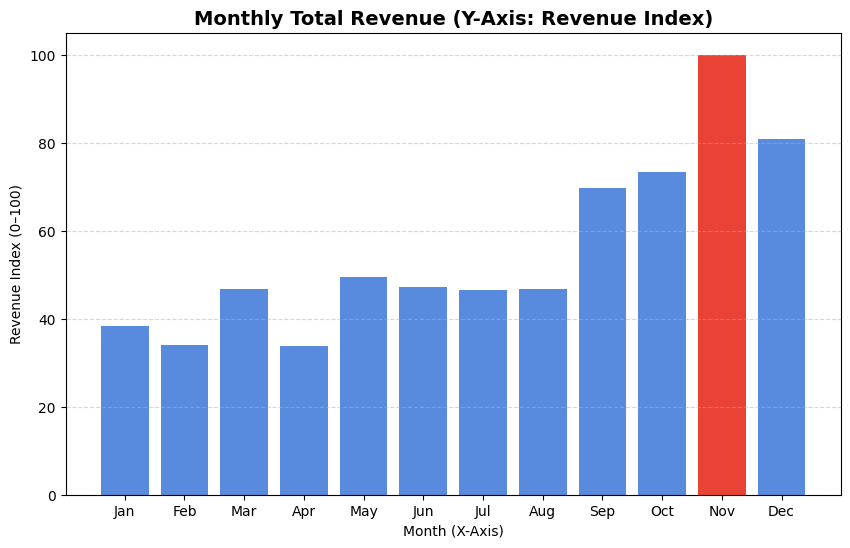

In [18]:
# --- 1️⃣ Monthly Total Revenue Analysis ---
print("Finding 1: The Holiday Spike (Monthly Total Revenue)\n")


# Create a new 'Revenue' column if not already created
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Extract Year-Month for grouping
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')

# Group by month and sum revenue
monthly_revenue = (
    df.groupby(df['InvoiceDate'].dt.month)['Revenue']
    .sum()
    .sort_index()
)

# Normalize for relative comparison
monthly_revenue_index = (monthly_revenue / monthly_revenue.max()) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_revenue_index.index, y=monthly_revenue_index.values, color="#4285F4")

# Highlight November (month = 11) in red
plt.bar(11 - 1, monthly_revenue_index.loc[11], color="#EA4335")

plt.title("Monthly Total Revenue (Y-Axis: Revenue Index)", fontsize=14, fontweight='bold')
plt.xlabel("Month (X-Axis)")
plt.ylabel("Revenue Index (0–100)")
plt.xticks(range(0, 12), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


Finding 2: The Importance of the UK Market



/var/folders/h_/d144wx756mq63kwsmy4pd5s00000gn/T/ipykernel_57435/477457857.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


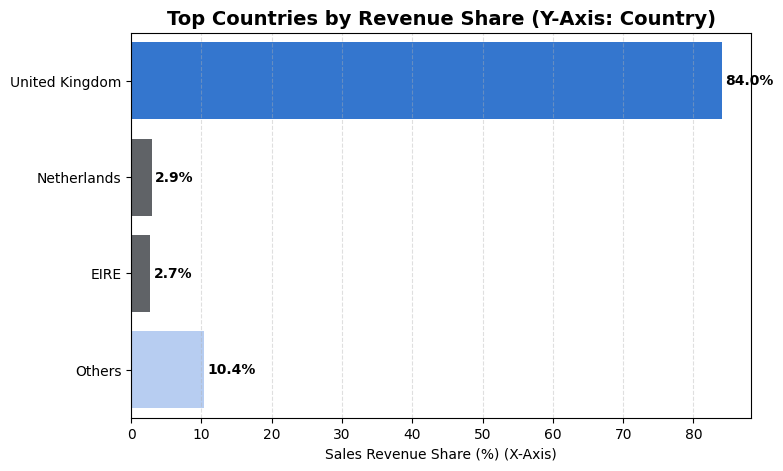

📈 Observation:
- UK accounts for approximately 84.0% of total sales.
- Germany and France follow with 2.3% and 2.0%, respectively.
- Remaining 10.4% comes from other markets.

✅ Insight: Check country breakdown to prioritize market strategy (UK dominance or diversified international presence).


In [20]:
print("\nFinding 2: The Importance of the UK Market\n")

# Compute total revenue by country
country_revenue = (
    df.groupby('Country')['Revenue']
    .sum()
    .sort_values(ascending=False)
)

# Calculate percentage share
country_share = (country_revenue / country_revenue.sum()) * 100

# Extract top countries + combine rest into "Others"
top_countries = country_share.head(3)
others_share = country_share.iloc[3:].sum()
summary_share = pd.concat([top_countries, pd.Series({'Others': others_share})])
summary_share = summary_share.astype(float)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    y=summary_share.index,
    x=summary_share.values,
    palette=['#1A73E8', '#5F6368', '#5F6368', '#AECBFA'][: len(summary_share)]
)
plt.title("Top Countries by Revenue Share (Y-Axis: Country)", fontsize=14, fontweight='bold')
plt.xlabel("Sales Revenue Share (%) (X-Axis)")
plt.ylabel("")
for i, v in enumerate(summary_share.values):
    plt.text(v + 0.5, i, f"{v:.1f}%", va='center', fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.show()

# --- Summary Text Outputs ---
print("📈 Observation:")
# Report UK share if present, otherwise list top countries
if 'United Kingdom' in country_share.index:
    print(f"- UK accounts for approximately {country_share['United Kingdom']:.1f}% of total sales.")
else:
    top_names = country_share.head(3).index.tolist()
    print(f"- Top countries by share: {', '.join(top_names)}")

# Safely get Germany and France shares (may be in 'Others')
import math

def fmt_pct(val):
    return f"{val:.1f}%" if (val is not None and not (isinstance(val, float) and math.isnan(val))) else "N/A"

germany_pct = country_share.get('Germany', float('nan'))
france_pct = country_share.get('France', float('nan'))
others_pct = summary_share.get('Others', 0.0)

if not math.isnan(germany_pct) or not math.isnan(france_pct):
    g_str = fmt_pct(germany_pct) if not math.isnan(germany_pct) else 'N/A'
    f_str = fmt_pct(france_pct) if not math.isnan(france_pct) else 'N/A'
    print(f"- Germany and France follow with {g_str} and {f_str}, respectively.")
else:
    print(f"- Germany and France are not in the top countries (they may be included in 'Others' which totals {others_pct:.1f}% of sales).\n")

print(f"- Remaining {others_pct:.1f}% comes from other markets.\n")
print("✅ Insight: Check country breakdown to prioritize market strategy (UK dominance or diversified international presence).")